In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

### Data Exploration

Pull in data.

In [2]:
data = pd.read_csv('data/avocado.csv')
data = data.drop(columns=['Unnamed: 0'])
data = data[data['region'] != 'TotalUS']
data = data.rename(columns={'4046' : 'Small Hass', '4225' : 'Large Hass', '4770' : 'XL Hass'})
data.columns = data.columns.str.replace(' ', '_')
data['Date'] = pd.to_datetime(data['Date'])
data = data.copy()
data.head()

,Date,AveragePrice,Total_Volume,Small_Hass,Large_Hass,XL_Hass,Total_Bags,Small_Bags,Large_Bags,XLarge_Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Descriptive statistics.

In [3]:
round(data.describe(), 2)

,Date,AveragePrice,Total_Volume,Small_Hass,Large_Hass,XL_Hass,Total_Bags,Small_Bags,Large_Bags,XLarge_Bags,year
count,17911,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00
mean,2016-08-13 23:30:10.351180800,1.41,539258.69,183807.41,188223.11,14551.23,152675.73,116202.87,34505.69,1967.17,2016.15
min,2015-01-04 00:00:00,0.44,84.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00
25%,2015-10-25 00:00:00,1.10,10571.02,819.66,2909.61,0.00,4905.20,2700.34,113.00,0.00,2015.00
50%,2016-08-14 00:00:00,1.37,100154.13,7824.43,26701.99,164.23,37551.02,24530.62,2459.22,0.00,2016.00
75%,2017-06-04 00:00:00,1.67,400176.68,101488.82,131755.22,5736.74,103691.60,79282.59,19421.71,106.76,2017.00
max,2018-03-25 00:00:00,3.25,11274749.11,5160896.68,5402444.45,804558.25,4145406.70,3403581.49,2838239.39,131300.76,2018.00
std,NaN,0.40,1224331.91,515105.86,451985.65,48817.54,364599.23,278759.60,113947.74,8186.40,0.94


Below is a plot of average daily volume by region. It appears that the larger the region (e.g. "West"), the more volume there is. This makes sense for obvious reasons. I believe that region will be key in trying to predict prices.

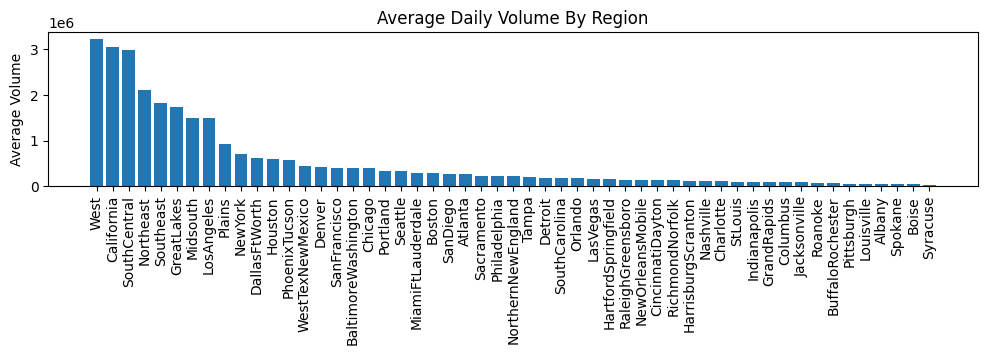

In [4]:
vol = data.drop(columns=['Date', 'type']).groupby('region').mean()['Total_Volume'].sort_values(ascending=False)

plt.figure(figsize=[12,2])
plt.bar(vol.index, vol)
plt.xticks(rotation=90)
plt.title('Average Daily Volume By Region')
plt.ylabel('Average Volume')
plt.show()

Below is a plot of average daily price by region. It appears that the farther you get from the southern US, the higher prices are.

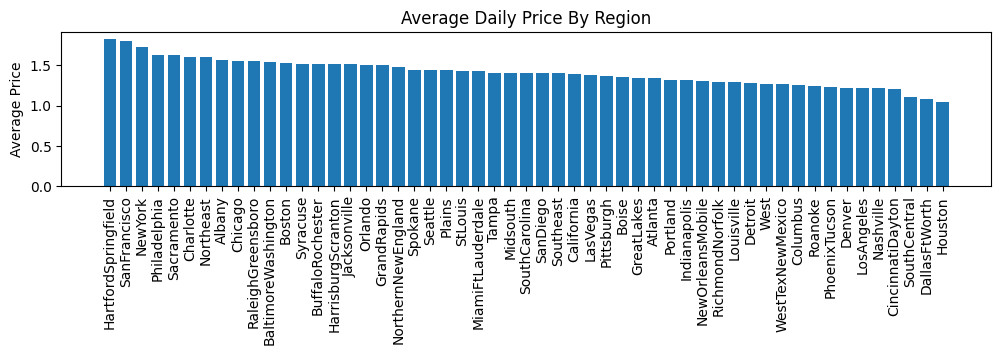

In [5]:
price = data.drop(columns=['Date', 'type']).groupby('region').mean()['AveragePrice'].sort_values(ascending=False)

plt.figure(figsize=[12,2])
plt.bar(price.index, price)
plt.xticks(rotation=90)
plt.title('Average Daily Price By Region')
plt.ylabel('Average Price')
plt.show()

Below is a plot of average daily prices across the entire US. We see a spike in the fall of 2016 and the fall of 2017. Although it is not entirely obvious, there may be some cyclicality to it.

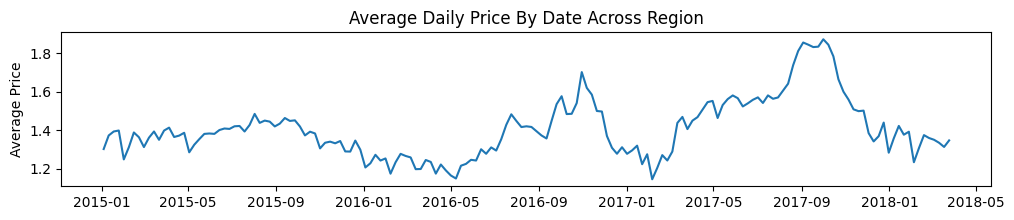

In [6]:
date_group = data.drop(columns=['region', 'type']).groupby('Date')

plt.figure(figsize=[12,2])
plt.plot(date_group.mean()['AveragePrice'])
plt.title('Average Daily Price By Date Across Region')
plt.ylabel('Average Price')
plt.show()

Below we plot all of the mean of features across regions, grouping by date. The data seem to show correlation with one another.

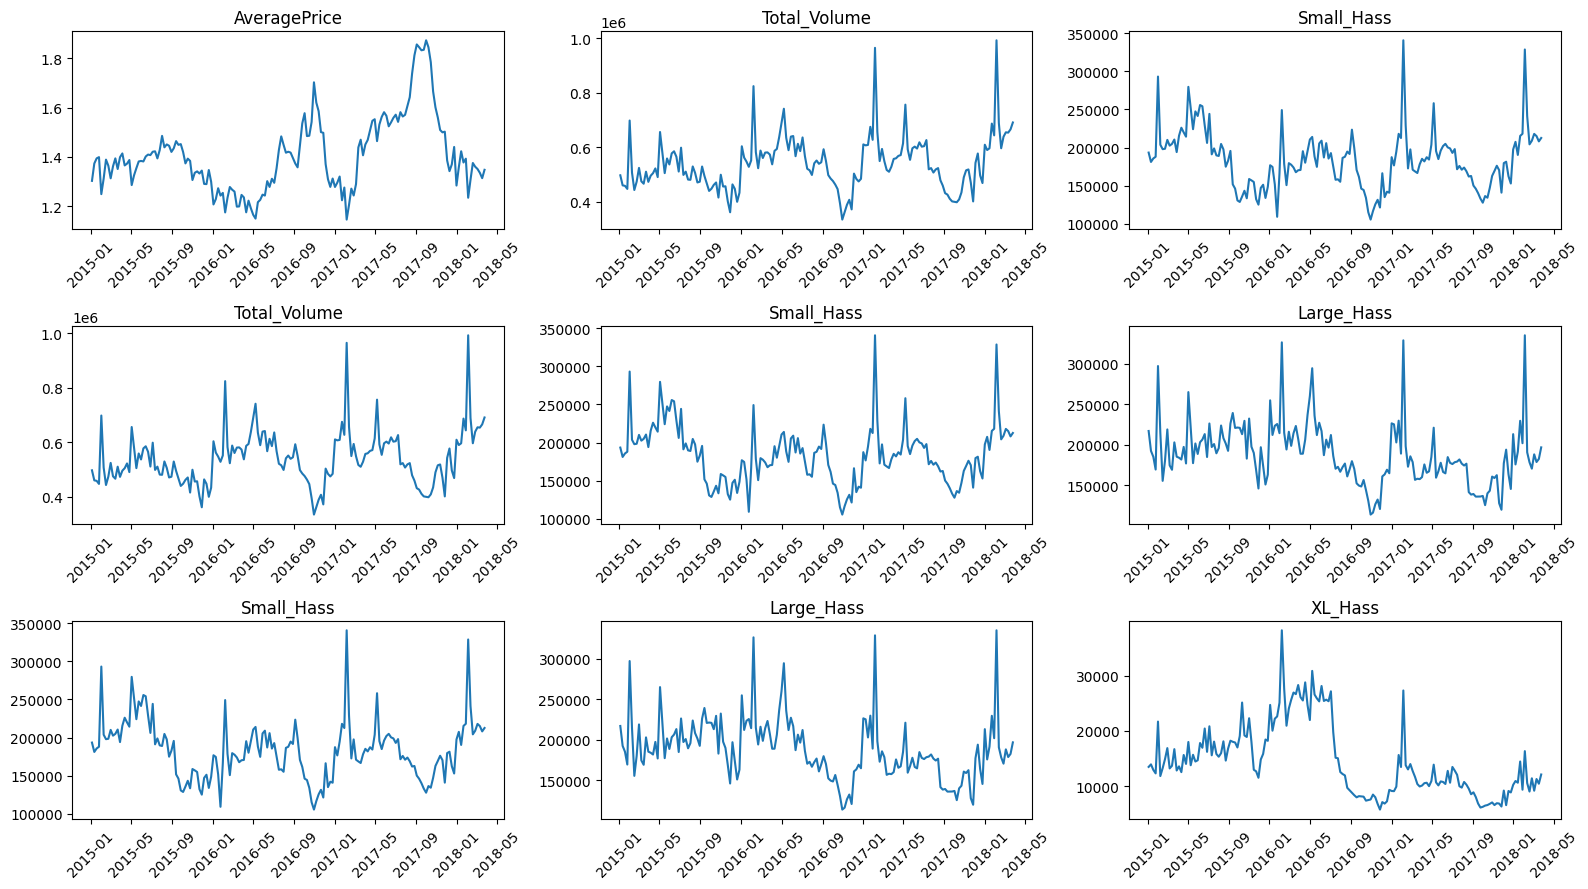

In [7]:
fig, axs = plt.subplots(3, 3, figsize=[16,9])

for i in range(3):
    for j in range(3):
        col = date_group.mean().iloc[:,i + j]
        
        axs[i][j].plot(col)
        
        axs[i][j].set_title(col.name)
        axs[i][j].tick_params(axis='x', labelrotation=45)
        
fig.tight_layout()
plt.show()

Below is a plot of the standard deviation of the features across regions, grouping by date. The mean is helpful for looking at general trends in the data, but the standard deviation can help show how much of an impact the region has on the features. It looks like there is some correlation between the mean of the data and the standard deviation.

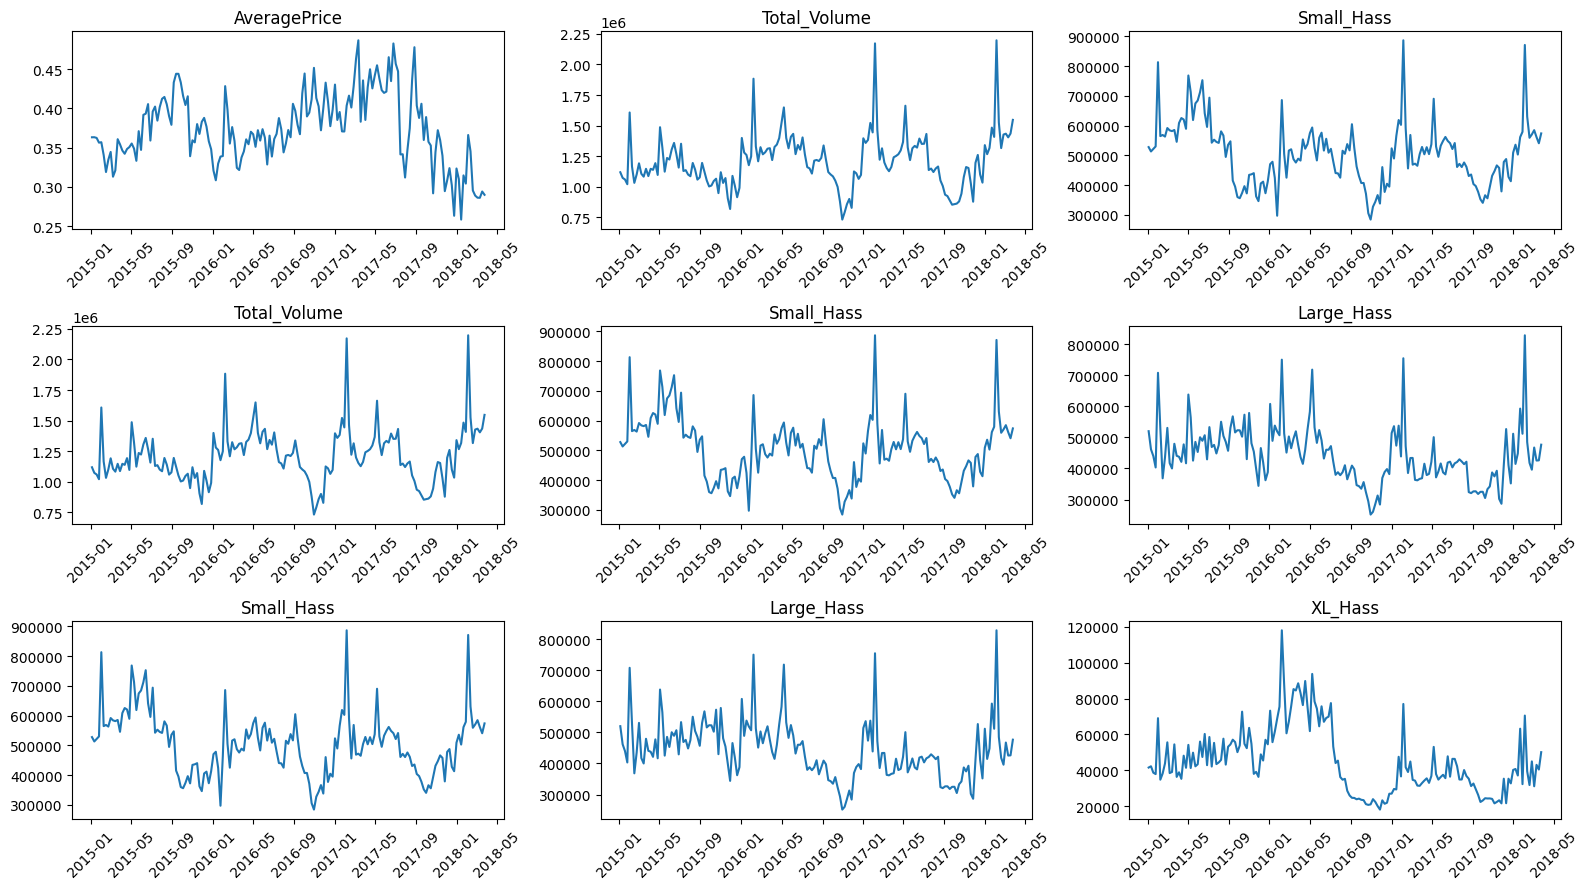

In [8]:
fig, axs = plt.subplots(3, 3, figsize=[16,9])

for i in range(3):
    for j in range(3):
        col = date_group.std().iloc[:,i + j]
        
        axs[i][j].plot(col)
        
        axs[i][j].set_title(col.name)
        axs[i][j].tick_params(axis='x', labelrotation=45)
        
fig.tight_layout()
plt.show()

Below is a table of correlations for the mean of the features across regions, grouping by date. It appears that average price and the number of Large and XL avocados that are sold are strongly negatively correlated. Correlations are strongly positive between the bag features.

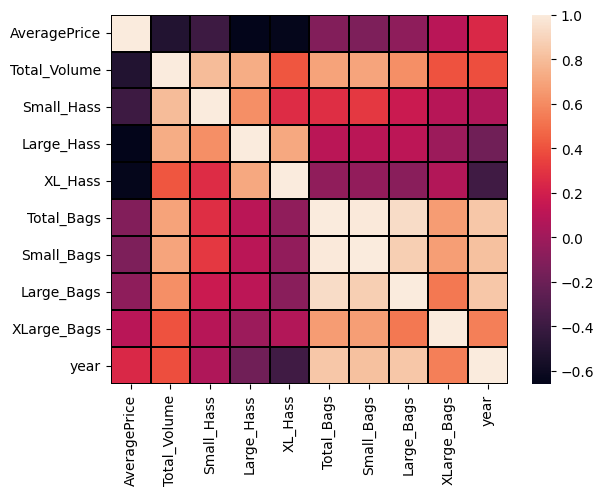

In [9]:
corr = pd.DataFrame(np.corrcoef(date_group.mean().T))
corr.columns = date_group.mean().columns
corr.index = date_group.mean().columns
sns.heatmap(corr, linecolor='Black', linewidths=.2)
plt.show()

### Data Cleaning

The Date feature is going to cause issues with the tenorflow processing. Because we believe the data may be cyclical in nature, we are going to convert the date feature to day of the year. We'll also add a month feature to capture the cyclicality as well.

In [10]:
data['Day_Of_Year'] = pd.Index(data['Date']).dayofyear
data['Month'] = pd.Index(data['Date']).month

Split data into X and y.

In [11]:
X = data.drop(columns=['AveragePrice', 'Date'])
y = data[['AveragePrice']]

We will split the data into a training set (60%), a test set (20%), and a validation set (20%).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=29)

Our data contains continuous data as well as categorical data. Dealing with the continuous data requires nothing but normalization. Dealing with the categorical data, on the other hand, is more work. To deal with the categorical data, we will use one-hot encoding. The continuous features are Total_Volume, Small_Hass, Large_Hass, XL_Hass, Total_Bags, Small_Bags, Large_Bags, and XLarge_Bags and year. The categorical features are type and region.

In [13]:
def process_data(X, y):
    X_con = X.drop(columns=['type', 'region'])
    X_cat = X[['type', 'region']]
    
    normalize = tf.keras.layers.Normalization(axis=1)
    normalize.adapt(X_con)
    X_con_norm = normalize(X_con)

    type_ = (X_cat[['type']] == 'conventional').astype(int)    # Only two options for type, so we can just make it binary
    type_ = np.array(type_)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(np.array(X_cat[['region']]))
    region = enc.transform(np.array(X_cat[['region']])).toarray()
    X_cat_norm = np.concatenate([type_, region], axis=1)

    X_norm = np.concatenate([X_con_norm, X_cat_norm], axis=1)

    normalize = tf.keras.layers.Normalization(axis=1)
    normalize.adapt(y)
    y_norm = normalize(y)

    return X_norm, y_norm

### Model Fitting

We will be using TensorFlow to implement our linear regression model. We will use mean squared error as our loss function.

In [14]:
def create_model(learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(65,)))
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)     # Use .legacy version on M1/M2 Macs
    loss = tf.keras.losses.MeanSquaredError()

    model.compile(loss=loss, optimizer=optimizer)

    return model

First we need to process our data by normalizing it. To normalize it we take each column of our feature dataframes and apply the following function:

$$ f(x) = \frac {X - \mu}{\sigma} $$

In [15]:
X_train_norm, y_train_norm = process_data(X_train, y_train)
X_val_norm, y_val_norm = process_data(X_val, y_val)
X_test_norm, y_test_norm = process_data(X_test, y_test)

print(X_train_norm.shape, y_train_norm.shape)
print(X_val_norm.shape, y_val_norm.shape)
print(X_test_norm.shape, y_test_norm.shape)

(10746, 65) (10746, 1)
(3582, 65) (3582, 1)
(3583, 65) (3583, 1)


Next, we instantiate an initial model to ensure that our create_model function is working.

In [16]:
tf.keras.utils.set_random_seed(12)
learning_rate = .1
model = create_model(learning_rate)
model.fit(X_train_norm, y_train_norm, epochs=50, batch_size=50)

Epoch 1/50
215/215 [==============================] - 0s 314us/step - loss: 0.5252
Epoch 2/50
215/215 [==============================] - 0s 288us/step - loss: 0.4908
Epoch 3/50
215/215 [==============================] - 0s 286us/step - loss: 0.4777
Epoch 4/50
215/215 [==============================] - 0s 286us/step - loss: 0.4782
Epoch 5/50
215/215 [==============================] - 0s 287us/step - loss: 0.4750
Epoch 6/50
215/215 [==============================] - 0s 287us/step - loss: 0.4801
Epoch 7/50
215/215 [==============================] - 0s 288us/step - loss: 0.4843
Epoch 8/50
215/215 [==============================] - 0s 286us/step - loss: 0.5014
Epoch 9/50
215/215 [==============================] - 0s 288us/step - loss: 0.5043
Epoch 10/50
215/215 [==============================] - 0s 282us/step - loss: 0.4904
Epoch 11/50
215/215 [==============================] - 0s 279us/step - loss: 0.5175
Epoch 12/50
215/215 [==============================] - 0s 279us/step - loss: 0.5209
E

Here are the different hyperparameter values that we will optimize the model to.

In [17]:
parameters = {'learning_rate' : [.1, .01, .001, .0001, .00001],
              'epochs' : [50, 75, 100, 150, 200],
              'batch_size' : [0.0, 0.1, 0.2, 0.3, 0.4]
}

We run a grid search to find the best hyperparameters. We will evaluate a model's fit by its accuracy on our validation set.

In [18]:
train_losses = {}
val_losses = {}

total = 1
for i in parameters.values():
    total *= len(i)

print('Models Fitted: %d/%d (%.2f%%)' % (0, total, 0), end='\r')
count = 1
for learning_rate in parameters['learning_rate']:
    for epochs in parameters['epochs']:
        for batch_size in parameters['batch_size']:            
            model = create_model(learning_rate)
            model.fit(X_train_norm,
                      y_train_norm,
                      epochs=epochs,
                      batch_size=int(batch_size * len(X_train_norm)),
                      validation_data=(X_val_norm, y_val_norm),
                      verbose=0)

            train_losses.update({(learning_rate, epochs, batch_size) : model.history.history['loss'][-1]})
            val_losses.update({(learning_rate, epochs, batch_size) : model.history.history['val_loss'][-1]})

            print('Models Trained: %d/%d (%.2f%%)' % (count, total, 100 * count / total), end='\r')
            count += 1

In [19]:
results = pd.DataFrame({'train_loss' : train_losses, 'val_loss' : val_losses})
results = results.reset_index()
results.columns = ['learning_rate', 'epochs', 'batch_size', 'train_score', 'val_score']
results = results.sort_values('val_score', ascending=True)
results.head()

,learning_rate,epochs,batch_size,train_score,val_score
50,0.0010,50,0.0,0.404112,0.410920
95,0.0001,200,0.0,0.402883,0.411055
49,0.0100,200,0.4,0.402811,0.411121
90,0.0001,150,0.0,0.403066,0.411211
70,0.0010,200,0.0,0.404095,0.411234


In [20]:
print('Our best model has the following parameters')

for key, value in round(results.iloc[0][:3], 3).to_dict().items():
    print(key, '=', value)

Our best model has the following parameters
learning_rate = 0.001
epochs = 50.0
batch_size = 0.0


We have the best hyperparameters from the grid search. In a normal scenario, when our grid search picks a hyperparameter that is on the upper or lower edge of the range that we are testing, we would normally want to re-run the gridsearch with a  We create a fresh model with those hyperparameters and train it on our training data.

In [21]:
model = create_model(results.iloc[0]['learning_rate'])
model.fit(X_train_norm,
          y_train_norm,
          epochs=int(results.iloc[0]['epochs']),
          batch_size=int(results.iloc[0]['batch_size'] * len(X_train_norm)),
          validation_data=(X_val_norm, y_val_norm))

Epoch 1/50
336/336 [==============================] - 0s 493us/step - loss: 0.8852 - val_loss: 0.7676
Epoch 2/50
336/336 [==============================] - 0s 383us/step - loss: 0.6737 - val_loss: 0.6283
Epoch 3/50
336/336 [==============================] - 0s 380us/step - loss: 0.5662 - val_loss: 0.5430
Epoch 4/50
336/336 [==============================] - 0s 385us/step - loss: 0.5000 - val_loss: 0.4902
Epoch 5/50
336/336 [==============================] - 0s 384us/step - loss: 0.4604 - val_loss: 0.4580
Epoch 6/50
336/336 [==============================] - 0s 383us/step - loss: 0.4372 - val_loss: 0.4392
Epoch 7/50
336/336 [==============================] - 0s 383us/step - loss: 0.4241 - val_loss: 0.4280
Epoch 8/50
336/336 [==============================] - 0s 381us/step - loss: 0.4161 - val_loss: 0.4213
Epoch 9/50
336/336 [==============================] - 0s 383us/step - loss: 0.4117 - val_loss: 0.4179
Epoch 10/50
336/336 [==============================] - 0s 376us/step - loss: 0.408

We visualize the convergence of the model's loss below. We can notice that although the loss of the training set goes down, the loss of the validation set rises. This might point to the idea that the model is being overfit on to the nuances of the training data and is therefore a worse fit on other data sets.

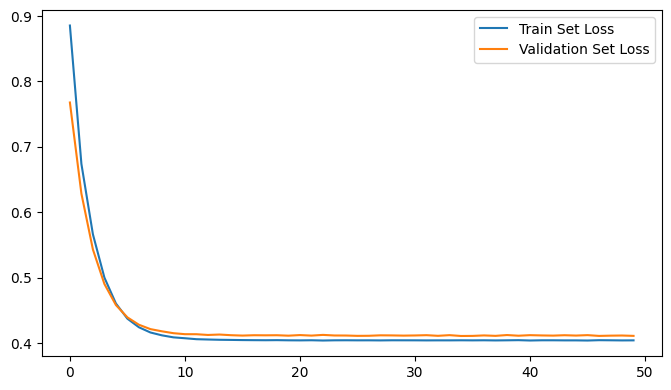

In [22]:
plt.figure(figsize=[8,4.5])
plt.plot(model.history.history['loss'], label='Train Set Loss')
plt.plot(model.history.history['val_loss'], label='Validation Set Loss')
plt.legend()
plt.show()

We apply our model to our test data below.

In [24]:
preds_test = model.predict(X_test_norm)
results_test = pd.DataFrame({'Target_Norm' : np.array(y_test_norm).T[0], 'Prediction_Norm' : preds_test.T[0]})
results_test['Difference_Norm'] = results_test['Target_Norm'] - results_test['Prediction_Norm']
normalize = tf.keras.layers.Normalization(axis=1, invert=True)
normalize.adapt(y_test)
results_test['Target'] = normalize(y_test_norm)
results_test['Prediction'] = normalize(preds_test)
results_test['Difference'] = results_test['Target'] - results_test['Prediction']
results_test.head()

112/112 [==============================] - 0s 280us/step


,Target_Norm,Prediction_Norm,Difference_Norm,Target,Prediction,Difference
0,0.898644,-0.082739,0.981383,1.79,1.391553,0.398447
1,-1.096404,-1.174992,0.078588,0.98,0.948093,0.031907
2,0.578451,-0.247968,0.826419,1.66,1.324469,0.335531
3,-0.456018,-0.081758,-0.374260,1.24,1.391952,-0.151952
4,0.701602,-0.332611,1.034213,1.71,1.290104,0.419896


In [25]:
print('Mean Absolute Error of Test Data: %.4f' % abs(results_test['Difference']).mean())

Mean Absolute Error of Test Data: 0.1994


Below is a scatter plot of our test data predictions and our actual test target values.

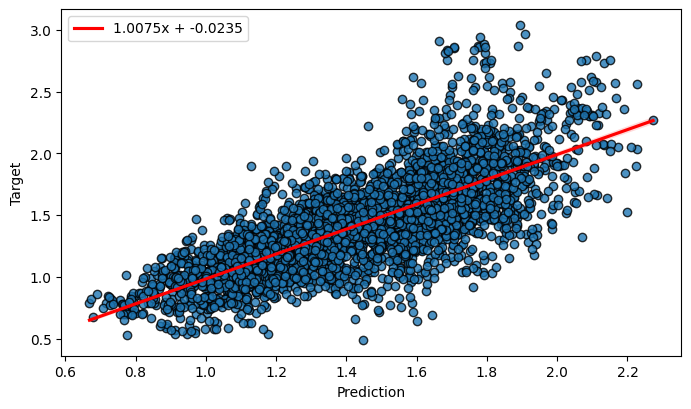

In [26]:
plt.figure(figsize=[8,4.5])
reg = ss.linregress(x=results_test['Prediction'], y=results_test['Target'])
sns.regplot(x=results_test['Prediction'],
            y=results_test['Target'],
            scatter_kws=dict(edgecolor='Black'),
            line_kws=dict(color='Red', label='%.4fx + %.4f' % (reg.slope, reg.intercept)))
plt.legend()
plt.show()

In [28]:
preds_train = model.predict(X_train_norm)
results_train = pd.DataFrame({'Target_Norm' : np.array(y_train_norm).T[0], 'Prediction_Norm' : preds_train.T[0]})
results_train['Difference_Norm'] = results_train['Target_Norm'] - results_train['Prediction_Norm']
normalize = tf.keras.layers.Normalization(axis=1, invert=True)
normalize.adapt(y_train)
results_train['Target'] = normalize(y_train_norm)
results_train['Prediction'] = normalize(preds_train)
results_train['Difference'] = results_train['Target'] - results_train['Prediction']
results_train.head()

336/336 [==============================] - 0s 256us/step


,Target_Norm,Prediction_Norm,Difference_Norm,Target,Prediction,Difference
0,-0.478564,-0.999147,0.520583,1.21,1.000213,0.209787
1,-0.428934,0.558165,-0.987099,1.23,1.627787,-0.397787
2,-1.446341,-1.073767,-0.372574,0.82,0.970142,-0.150142
3,1.084768,-0.304916,1.389684,1.84,1.279978,0.560022
4,-0.602638,-0.462045,-0.140593,1.16,1.216657,-0.056657


In [29]:
print('Mean Absolute Error of Train Data: %.4f' % abs(results_train['Difference']).mean())

Mean Absolute Error of Train Data: 0.1932


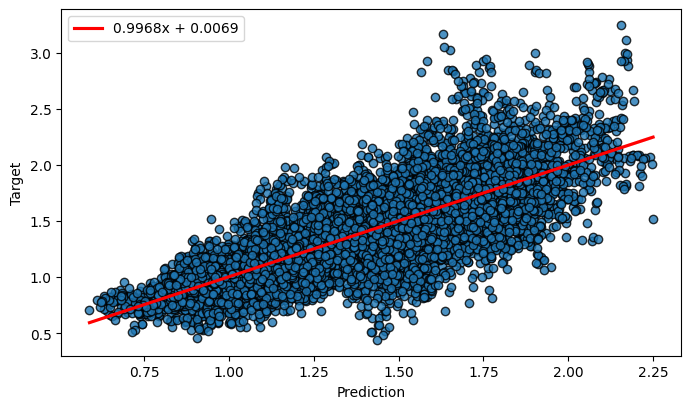

In [30]:
plt.figure(figsize=[8,4.5])
reg = ss.linregress(x=results_train['Prediction'], y=results_train['Target'])
sns.regplot(x=results_train['Prediction'],
            y=results_train['Target'],
            scatter_kws=dict(edgecolor='Black'),
            line_kws=dict(color='Red', label='%.4fx + %.4f' % (reg.slope, reg.intercept)))
plt.legend()
plt.show()